## Simulation

In [144]:
import sqlite3
from db_init import db_init
import simpy
import Dijkstra
import datetime
import numpy as np
import pandas as pd
import random
import math
from scipy.stats import lognorm, beta
np.random.seed(42)
# Klasse Produkt definieren - Attribute siehe DB
class Produkt:
    def __init__(self, id, bezeichnung, dlz_plan, losgroesse, bestand_rtl, bestand_ftl, bestellbestand):
        self.id = id
        self.bezeichnung = bezeichnung
        self.dlz_plan = dlz_plan
        self.losgroesse = losgroesse
        self.bestand_rtl = bestand_rtl
        self.bestand_ftl = bestand_ftl        
        self.bestellbestand = bestellbestand

# Überschreiben der __repr__ Methode, damit die Objekte als Klartext beim Printen angezeigt werden
    def __repr__(self):
        return (f"Produkt(id={self.id}, bezeichnung='{self.bezeichnung}', dlz_plan={self.dlz_plan}, "
                f"losgroesse={self.losgroesse}, bestand_rtl={self.bestand_rtl}, bestand_ftl={self.bestand_ftl})")

# Klasse Auftrag definieren - Attribute siehe DB
class Auftrag:
    def __init__(self, charge, id, menge, art):
        self.charge = charge
        self.id = id
        self.arbeitsplan = []
        self.menge = menge
        self.start = None
        self.art = art
    
    # Überschreiben der __repr__ Methode, damit die Objekte als Klartext beim Printen angezeigt werden
    def __repr__(self):
        return f"Auftrag(charge={self.charge}, id={self.id}, arbeitsplan={self.arbeitsplan}, menge={self.menge}, start={self.start}, art={self.art})"

# Klasse FFZ definieren - Attribute siehe DB
class FFZ:
    def __init__(self, id, speed, akkulaufzeit):
        self.id = id
        self.speed = speed
        self.akkulaufzeit = akkulaufzeit
        self.akkustand = akkulaufzeit
        self.curr_location = "g"
        self.curr_transport = None
        self.queue = []
    
    # Überschreiben der __repr__ Methode, damit die Objekte als Klartext beim Printen angezeigt werden
    def __repr__(self):
        return f"Auftrag(id={self.id})"
    
# Klasse Factory definieren
class Factory:
    def __init__(self, env, db_path, start_datum, schichtregime, add_auftrag):
        self.env = env # Simulationsumgebung
        self.db_path = db_path # Pfad zur Datenbank
        self.start_datum = start_datum
        self.schichtregime = schichtregime
        self.db() 
        env.process(self.kalender(env))
        self.lade_produkte()
        self.lade_ffz()
        self.saegen_queue = []
        self.saegen_status = "v"
        # v - verfügbar, b - belegt, d - defekt
        self.drehen_queue = []
        self.drehen_queue_intern = []
        self.drehen_1_status = "v"
        self.drehen_2_status = "v"
        self.fraesen_queue = []
        self.fraesen_status = "v"
        self.pruefen_queue = []
        self.pruefen_status = "v"
        self.haerten_queue = []
        self.haerten_status = "v"
        self.transport_queue = []
        self.factory_status = True
        self.add_auftrag = add_auftrag

        env.process(self.absatz(env))
        env.process(self.check_factory_status(env))
        env.process(self.insert_add_auftrag(env))
        env.process(self.ladevorgang(env))
        # Dijkstra
        self.graph = Dijkstra.graph([
        ("a", "b", 60), ("b", "a", 60),
        ("a", "c", 70), ("c", "a", 70),
        ("a", "d", 75), ("d", "a", 75),
        ("b", "c", 25), ("c", "b", 25),
        ("b", "d", 45), ("d", "b", 45),
        ("c", "g", 40), ("g", "c", 40),
        ("d", "e", 85), ("e", "d", 85),
        ("g", "e", 30), ("e", "g", 30),
        ("e", "f", 85), ("f", "e", 85),
        ("g", "h", 45), ("h", "g", 45),
        ("e", "h", 55), ("h", "e", 55),
        ])

        self.schichtzeiten = {
            'S1': {'start': '06:00', 'end': '14:00'}, # Ein-Schicht Regime 
            'S2': {'start': '06:00', 'end': '22:00'}, # Zwei-Schicht Regime
            'S3': {'start': '00:00', 'end': '00:00'}, # irrelevant, weil es dann keine Einschränkungen gibt
        }
        # Variable zum Speichern der aktuellen Laufzeit ohne Ausfall, dem simulierten nächsten Ausfall, der mittlere Zeit zwischen der Ausfällen und der Reparationszeit
        self.machine_param = {
            "SAE": {'sum_workload': 50, 'next_failure': 1800, 'mean_runtime': 960, 'maintenance_time': 80},
            "DRH1": {'sum_workload': 450, 'next_failure': 1300, 'mean_runtime': 1100, 'maintenance_time': 90},
            "DRH2": {'sum_workload': 200, 'next_failure': 1900, 'mean_runtime': 900, 'maintenance_time': 125},
            "FRA": {'sum_workload': 700, 'next_failure': 2000, 'mean_runtime': 880, 'maintenance_time': 75},
            "HAE": {'sum_workload': 1000, 'next_failure': 2500, 'mean_runtime': 1500, 'maintenance_time': 180},
        }

    # DB Verbindung herstellen
    def db(self):
        self.conn = sqlite3.connect(self.db_path)
        self.cursor = self.conn.cursor()

    # Kalender Aktualisierung
    def kalender(self, env):
        while True:
            self.uhrzeit = self.start_datum + datetime.timedelta(seconds = round(env.now*60))
            #self.uhrzeit = self.uhrzeit.strftime("%Y-%m-%d %H:%M:%S")
            yield env.timeout(0.1)  

    def check_factory_status(self, env):    
        while True:
            # bestimme aktuelle Zeit
            aktuelle_uhrzeit = self.uhrzeit.strftime("%H:%M")

            # Wochentag bestimmen (0 = Montag, ..., 6 = Sonntag)
            wochentag = self.uhrzeit.weekday()

            # Überprüfen, ob es ein Wochenende ist (Samstag oder Sonntag)
            if wochentag == 5 or wochentag == 6:  # 5 = Samstag, 6 = Sonntag
                self.factory_status = False
            else:
                if self.schichtregime == 'S1':
                    if self.schichtzeiten['S1']['start'] <= aktuelle_uhrzeit <= self.schichtzeiten['S1']['end']:
                        self.factory_status = True
                    else:
                        self.factory_status = False
                elif self.schichtregime == 'S2':
                    if self.schichtzeiten['S2']['start'] <= aktuelle_uhrzeit <= self.schichtzeiten['S2']['end']:
                        self.factory_status = True
                    else:
                        self.factory_status = False

            yield env.timeout(1)

    # Funktion die Überprüft, ob ein Arbeitsschritt bzw. ein Transport ausgeführt werden kann, ohne eine Arbeitszeitüberschreitung zu verursachen
    def check_for_soon_shotdown(self, timeout, env):
        
        if self.schichtregime == 'S1':
            while ((self.uhrzeit + datetime.timedelta(minutes=timeout)).strftime("%H:%M") >= self.schichtzeiten['S1']['end']) or (
            (self.uhrzeit.strftime("%H:%M") <= self.schichtzeiten['S1']['start']) or (
             (self.uhrzeit + datetime.timedelta(minutes=timeout)).strftime("%H:%M") <= self.schichtzeiten['S1']['start']) or (self.factory_status == False)):
                yield env.timeout(0.1)
            
        elif self.schichtregime == 'S2':
            while ((self.uhrzeit + datetime.timedelta(minutes=timeout)).strftime("%H:%M") >= self.schichtzeiten['S2']['end']) or (
            (self.uhrzeit.strftime("%H:%M") <= self.schichtzeiten['S2']['start']) or (
             (self.uhrzeit + datetime.timedelta(minutes=timeout)).strftime("%H:%M") <= self.schichtzeiten['S2']['start']) or (self.factory_status == False)):
                yield env.timeout(0.1)
        
        else:
            while self.factory_status == False:
                yield env.timeout(0.1)

    # Funktion welche die Zeiten der Bearbeitungsvorgänge simuliert
    def run_time(self, arbeitsschritt, auftrag, bmg, env):
        ausschussrate = {
            "SAE": 0.005,
            "DRH1": 0,
            "DRH2": 0,
            "FRA": 0.03,
            "HAE": 0.05,
            "QPR": 0.01
        }

        # Überprüfen von Fehlerzuständen 
        if bmg != "QPR":
            yield env.process(self.check_down_time(bmg, env))

        # Rüstvorgang
        start_ruesten = self.uhrzeit
        
       
        # Bearbeitungsvorgang
        start_bearbeitung = self.uhrzeit

        # Ziehen der tatsächlichen Rüstzeit
        # Gegebene Parameter für die Log-Normalverteilung
        M = arbeitsschritt[2]*auftrag.menge  # Mittelwert der Log-Normalverteilung
        sigma_L = M / 15  # Standardabweichung der Log-Normalverteilung -> 6,67 % der Bearbeitungszeit

        # Berechne die Parameter der zugrunde liegenden Normalverteilung
        sigma = np.sqrt(np.log(1 + (sigma_L**2 / M**2)))  # Standardabweichung der Normalverteilung
        mu = np.log(M) - 0.5 * sigma**2  # Mittelwert der Normalverteilung

        # Ziehe einen zufälligen Wert aus der Log-Normalverteilung
        zeit = lognorm.rvs(sigma, scale=np.exp(mu), size=1)     
        zeit_maintanance = zeit[0]

        while zeit[0] > 0:
            while self.factory_status == False:
                yield env.timeout(1)

            zeit -= 1
            yield env.timeout(1)
        
        ende_bearbeitung = self.uhrzeit  

        if bmg != "QPR":
            self.machine_param[bmg]['sum_workload'] += zeit_maintanance
       

        ausschuss = int(np.random.binomial(auftrag.menge, ausschussrate[bmg], 1)[0])
        auftrag.menge -= ausschuss

        # Einträge in DB pflegen
        self.cursor.execute('INSERT INTO FLF (Charge, bmg, start_ruesten, start_bearbeitung, ende_bearbeitung, anzahl_bauteile, ausschuss) VALUES (?, ?, ?, ?, ?, ?, ?)', 
                            (auftrag.charge, bmg, start_ruesten, start_bearbeitung, ende_bearbeitung, int(auftrag.menge), ausschuss))
        self.conn.commit()

    def check_down_time(self, bmg, env):
        if self.machine_param[bmg]['sum_workload'] >= self.machine_param[bmg]['next_failure']:
            start_down_time = self.uhrzeit
            
            yield env.timeout(self.machine_param[bmg]['maintenance_time'])
            self.machine_param[bmg]['sum_workload'] = 0

            end_down_time = self.uhrzeit

            # Einträge in DB pflegen
            self.cursor.execute('INSERT INTO ELF (bmg, start_downtime, end_downtime) VALUES (?, ?, ?)', 
                            (bmg, start_down_time, end_down_time))
            self.conn.commit()

            # next down time
            target_mean = self.machine_param[bmg]['mean_runtime']
            alpha_param = 5
            beta_param = 2

            standard_mean = alpha_param / (alpha_param + beta_param)
            scaling_factor = target_mean / standard_mean

            # Ziehe einen Wert aus der Beta-Verteilung im Bereich [0, 1]
            beta_value = beta.rvs(alpha_param, beta_param)

            # Skaliere diesen Wert auf den gewünschten Bereich
            next_down_time = beta_value * scaling_factor
            self.machine_param[bmg]['next_failure'] = next_down_time

    # Erstelle Produkt Objekte auf Basis der Produktstammdaten siehe db
    def lade_produkte(self):
        self.produkte = []

        # Produkte aus der Tabelle produktstammdaten abrufen
        self.cursor.execute('SELECT * FROM produktstammdaten')
        rows = self.cursor.fetchall()

        # Für jede Zeile ein Produkt-Objekt erstellen
        for row in rows:
            produkt = Produkt(id=row[0], bezeichnung=row[1], dlz_plan=row[2], losgroesse=row[3], bestand_rtl=row[4], bestand_ftl=row[5], bestellbestand=row[6])
            self.produkte.append(produkt)
            # Name des Objekts entspricht der Bezeichnung
            globals()[produkt.bezeichnung] = produkt

    def lade_ffz(self):
        self.ffzs = []

        self.cursor.execute('SELECT * FROM ffz')
        rows = self.cursor.fetchall()

        for row in rows:
            ffz = FFZ(id=row[0], speed=row[1], akkulaufzeit=row[2])
            self.ffzs.append(ffz)    

    # Finde Source und Destination des Transports
    def find_source_destination(self, arbeitsschritt, folgeschritt):
        # Dictionary mit den Standorten der Arbeitsstationen
        location_map = {
            'RTL': 'a',  # RTL an Standort A
            'SAE': 'b',  # Sägen an Standort B
            'DRH': 'c',  # Drehen an Standort C
            'FRA': 'd',  # Fräsen an Standort D
            'QPR': 'e',  # Prüfen an Standort D
            'FTL': 'f',  # Fertigteillager an Standort E
            'HAE': 'h'
        }

        # Bestimme den Standort für den aktuellen Arbeitsschritt
        if arbeitsschritt is not None:
            source = location_map.get(arbeitsschritt[0])
        else: 
            source = location_map.get('RTL')

        if folgeschritt is not None:
            destination = location_map.get(folgeschritt[0])
        else:
            destination = location_map.get('FTL')

        return source, destination
    
    # Berechnet den Bestand in (ZE) an dem Durchsatzengpass
    def bestand_engpass(self):
        """Berechnet die Summe aller Rüst- und Bearbeitungszeiten für Aufträge in der drehen_queue."""
        total_ruestzeit = 0
        total_bearbeitungszeit = 0

        # Iteriere über alle Aufträge in der drehen_queue
        for auftrag in self.drehen_queue:
            for arbeitsschritt in auftrag.arbeitsplan:
                # Prüfen, ob der Arbeitsschritt zu 'DRH' (Drehen) gehört
                if arbeitsschritt[0] == 'DRH':
                    total_ruestzeit += arbeitsschritt[1]
                    total_bearbeitungszeit += arbeitsschritt[2]*auftrag.menge

        gesamtzeit = total_ruestzeit + total_bearbeitungszeit
        return gesamtzeit

    def insert_add_auftrag(self, env):
        self.freigabe_liste = []
        
        # Suche nach den Arbeitsschritten
        if self.add_auftrag == None:
            pass
        else:
            for auftrag in self.add_auftrag:
                while datetime.datetime.strptime(auftrag.start, "%d.%m.%Y %H:%M") > self.uhrzeit:   
                    yield env.timeout(1)
                
                self.cursor.execute('INSERT INTO auftraege (id, stueckzahl_plan, art) VALUES (?, ?, ?)', (auftrag.id, auftrag.menge, "ZU"))
                # Abrufen der Charge für den letzten eingefügten Auftrag
                self.cursor.execute('SELECT charge FROM auftraege ORDER BY charge DESC LIMIT 1')
                charge = self.cursor.fetchone()[0]  

                # Erstellen eines Auftrag-Objekts
                auftrag.charge = charge           
                self.cursor.execute('SELECT bmg, r_plan, t_plan, nr FROM arbeitsplaene WHERE id=? ORDER BY nr ASC', (auftrag.id,))
                rows = self.cursor.fetchall()  
                # Alle Arbeitsplan-Einträge zum Auftrag hinzufügen
                for row in rows:
                    auftrag.arbeitsplan.append(row)

                self.freigabe_liste.insert(0, auftrag)

                produkt = None
                for p in self.produkte:
                    if p.id == auftrag.id:
                        produkt = p
                        break

                env.process(self.auftragsfreigabe(auftrag, produkt, env))
            

    # Auftragsfreigabe, bei Unterschreitung des Planbestands am Durchsatz Engpass (hier DRH) 
    def auftragsfreigabe(self, auftrag, produkt, env):
        """Führt die Produktionsschritte für einen gegebenen Auftrag durch.
        Args:
        auftrag: Das Auftrag-Objekt, das die Arbeitspläne enthält.
        produkt: Das Produkt, das bearbeitet wird.
        env: Die SimPy-Umgebung, die die Simulation verwaltet.
        """       
        status = False
        
        # kontinuierliche Prüfung der Freigabekriterien 
        while status == False:
            while self.factory_status == False:
                
                yield env.timeout(1)
            
            self.bestand_am_engpass = self.bestand_engpass() # aktualisiert den bestand am Engpass
            
            # gibt Auftrag frei, wenn der Auftrag den Engpass durchläuft, der Auftrag der erste der liste ist und der Bestand am Engpass den Planbestand unterschreitet
            if self.freigabe_liste[0] == auftrag and self.bestand_am_engpass < 1900 and any(step[0] == 'DRH' for step in auftrag.arbeitsplan):
                status = True
                self.freigabe_liste.remove(auftrag)
                break
            
            # Aufträge nicht über den Engpass laufen werden sofort freigegeben 
            elif not any(step[0] == 'DRH' for step in auftrag.arbeitsplan):
                status = True
                self.freigabe_liste.remove(auftrag)

            else:
                yield env.timeout(1)
        
        # Freigabe in DB pflegen
        self.cursor.execute('''UPDATE auftraege SET freigabe = ? WHERE Charge = ?''', 
                                (self.uhrzeit, auftrag.charge))
        self.conn.commit()

        # Stationen
        workstations = {
            'SAE': self.saegen,
            'DRH': self.drehen,
            'QPR': self.pruefen,
            'FRA': self.fraesen,
            'HAE': self.haerten
        }

        # Queues
        queues = {
            'SAE': self.saegen_queue,
            'DRH': self.drehen_queue,
            'QPR': self.pruefen_queue,
            'FRA': self.fraesen_queue,
            'HAE': self.haerten_queue
        }

        # Zuordnung der Queues nach erfolgreicher Auftragsfreigabe
        for arbeitsschritt in auftrag.arbeitsplan:
        # Hole die Bearbeitungsfunktion und Queue der entsprechenden Arbeitsstation
            station_queue = queues.get(arbeitsschritt[0])

            # Füge den Auftrag der Queue der Station hinzu
            station_queue.append(auftrag)

        # Auftragsfreigabe in DB protokollieren 

        # Eintrag in DB zur Protokollierung des Lagereingangs
        freigabe = self.uhrzeit
        self.cursor.execute('INSERT INTO FLF (ankunft, charge, bmg) VALUES (?, ?, ?)', 
                          (freigabe, auftrag.charge, 'RTL'))
        self.conn.commit()

        for i, arbeitsschritt in enumerate(auftrag.arbeitsplan):
            # Transport aus RTL für 1. Arbeitsschritt
            if arbeitsschritt == auftrag.arbeitsplan[0]:
                # Bestimme Source und Destination
                source, destination = self.find_source_destination(None, arbeitsschritt)
                # Transport
                yield env.process(self.transport(auftrag, source, destination, arbeitsschritt, env))
                ankunft = self.uhrzeit
            else: # Ankunft aller anderen Aufträge
                ankunft = self.uhrzeit

            # Start Bearbeitungsprozess            
            yield env.process(workstations.get(arbeitsschritt[0])(auftrag, arbeitsschritt, env))

            # Nächster Arbeitsschritt (falls vorhanden)
            folgeschritt = auftrag.arbeitsplan[i + 1] if i + 1 < len(auftrag.arbeitsplan) else None
  
            # Bestimme Source und Destination
            source, destination = self.find_source_destination(arbeitsschritt, folgeschritt)

            # Transport 
            yield env.process(self.transport(auftrag,source, destination, arbeitsschritt, env))

            # Einträge in DB pflegen
            self.cursor.execute('''UPDATE FLF SET ankunft = ? WHERE Charge = ? AND bmg like ?''', 
                                (ankunft, auftrag.charge, arbeitsschritt[0] + '%'))
            self.conn.commit()

            # Falls der letzte Arbeitsschritt ausgeführt wurde:
            if arbeitsschritt == auftrag.arbeitsplan[-1]:
                # Auftrag aus Auftragsliste entfernen                            
                if auftrag.art == "PP":
                    # Bestand um die Losgröße erhöhen
                    produkt.bestand_ftl += produkt.losgroesse
                    self.auftraege.remove(auftrag)
                    # Bestand des Produkts in der Datenbank aktualisieren
                    self.cursor.execute('UPDATE produktstammdaten SET bestand_ftl = ? WHERE id = ?', (produkt.bestand_ftl, produkt.id))

                
                # Eintrag in DB zur Protokollierung des Lagereingangs
                ankunft_ftl = self.uhrzeit
                self.cursor.execute('INSERT INTO FLF (ankunft, charge, bmg) VALUES (?, ?, ?)', 
                        (ankunft_ftl, auftrag.charge, 'FTL'))
                
                # Bearbeitungsenge in DB pflegen
                self.cursor.execute('''UPDATE auftraege SET fertigstellung = ?, stueckzahl_ist = ? WHERE Charge = ?''', 
                                (self.uhrzeit, auftrag.menge, auftrag.charge))
                self.conn.commit()          

    ##### Produktionsfunktionen
    def saegen(self, auftrag, arbeitsschritt, env):
        # Prüfen ob die Maschine belegt ist       
        while self.saegen_status == ("b" or "d") or self.saegen_queue[0] != auftrag:
            yield env.timeout(1)
        
        # Status belegt, bei Start der Bearbeitung
        self.saegen_status = "b"

        # Simulation der Bearbeitungszeiten
        yield env.process(self.run_time(arbeitsschritt, auftrag, arbeitsschritt[0], env))

        # Status verfügbar, bei Ende der Bearbeitung
        self.saegen_status = "v"

        # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
        self.saegen_queue.remove(auftrag)

    def drehen(self, auftrag, arbeitsschritt, env):
        # Aufbau der weiteren Produktionsfunktionen analog der ersten
        # Besonderheit beim Drehen: 2 Arbeitssysteme        
        # Füge Auftrag zur internen Queue hinzu
        self.drehen_queue_intern.append(auftrag)
        
        while (self.drehen_1_status == ("b" or "d") and self.drehen_2_status == ("b" or "d")) or self.drehen_queue_intern[0] != auftrag:
            yield env.timeout(1)

        if self.drehen_1_status == "v":

            self.drehen_1_status = "b"

            # Entferne Auftrag aus interner Queue
            self.drehen_queue_intern.remove(auftrag)

            # Simulation der Bearbeitungszeiten
            yield env.process(self.run_time(arbeitsschritt, auftrag, "DRH1", env))

            # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
            self.drehen_queue.remove(auftrag)

            self.drehen_1_status = "v"

        elif self.drehen_2_status == "v":

            self.drehen_2_status = "b"

            # Entferne Auftrag aus interner Queue
            self.drehen_queue_intern.remove(auftrag)

            # Simulation der Bearbeitungszeiten
            yield env.process(self.run_time(arbeitsschritt, auftrag, "DRH2", env))

            # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
            self.drehen_queue.remove(auftrag)

            self.drehen_2_status = "v"

    def fraesen(self, auftrag, arbeitsschritt, env):
        # Prüfen ob die Maschine belegt ist
        while self.fraesen_status == ("b" or "d") or self.fraesen_queue[0] != auftrag:
            yield env.timeout(1)
        
        # Status belegt, bei Start der Bearbeitung
        self.fraesen_status = "b"

        # Simulation der Bearbeitungszeiten
        yield env.process(self.run_time(arbeitsschritt, auftrag, arbeitsschritt[0], env))
        
        # Status verfügbar, bei Ende der Bearbeitung
        self.fraesen_status = "v"

        # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
        self.fraesen_queue.remove(auftrag)
           
    def pruefen(self, auftrag, arbeitsschritt, env):
        # prüfen ob die Maschine belegt ist
        while self.pruefen_status == ("b" or "d") or self.pruefen_queue[0] != auftrag:
            yield env.timeout(1)
        
        self.pruefen_status = "b"
        
        # Simulation der Bearbeitungszeiten
        yield env.process(self.run_time(arbeitsschritt, auftrag, arbeitsschritt[0], env))

        self.pruefen_status = "v"

        # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
        self.pruefen_queue.remove(auftrag)

    def haerten(self, auftrag, arbeitsschritt, env):
        # prüfen ob die Maschine belegt ist
        while self.haerten_status == ("b" or "d") or self.haerten_queue[0] != auftrag:
            yield env.timeout(1)
        
        self.haerten_status = "b"
        
        # Simulation der Bearbeitungszeiten
        yield env.process(self.run_time(arbeitsschritt, auftrag, arbeitsschritt[0], env))

        self.haerten_status = "v"

        # Entferne den Auftrag nach der Bearbeitung aus der Warteschlange
        self.haerten_queue.remove(auftrag)

    ##### Transportfunktionen
    def transport(self, auftrag, source, destination, arbeitsschritt, env):
        status = False
        self.transport_queue.append(auftrag)

        # Fortlaufende Überprüfung ob FFZ verfügbar ist
        while status == False:
            found_auftrag = False
            for ffz in self.ffzs:
                if ffz.curr_transport == None and self.transport_queue[0] == auftrag:
                    # Zuweisen des Auftrags zu FFZ
                    ffz.curr_transport = auftrag
                    
                    self.transport_queue.remove(auftrag)                 
                    # Berechnung der Distance des FFZs zur Source mit Dijkstra Algorithmus
                    distance_to_source = self.graph.dijkstra(ffz.curr_location, source)[1] # self.graph.dijkstra("a", "d")[0] für gewählte Route
                    route_to_source = self.graph.dijkstra(ffz.curr_location, source)[0]
                    route_as_string = '->'.join(route_to_source)

                    # Berechnung der Fahrdauer zur Source
                    duration_to_source =  math.ceil((distance_to_source / ffz.speed) / 60)

                    # Energieverbrauch
                    ffz.akkustand -= distance_to_source
                    if distance_to_source > 0:
                        # Fahrt zur Source 
                        yield env.process(self.check_for_soon_shotdown(duration_to_source, env))
                        yield env.timeout(duration_to_source)

                        
                        # Fahrt in TLF eintragen
                        self.cursor.execute('INSERT INTO TLF (FFZ_id, start_knoten, end_knoten, route, startzeitpunkt, endzeitpunkt, akkustand) VALUES (?, ?, ?, ?, ?, ?, ?)', 
                                (ffz.id, ffz.curr_location, source, route_as_string, self.uhrzeit - datetime.timedelta(minutes=duration_to_source), self.uhrzeit, ffz.akkustand/ffz.akkulaufzeit))

                    # Abtransport in FLT pflegen
                    abtransport = self.uhrzeit
                    self.cursor.execute('''UPDATE FLF SET abtransport = ? WHERE Charge = ? AND bmg like ?''', 
                                        (abtransport, auftrag.charge, arbeitsschritt[0] + '%'))
                    self.conn.commit()
                   
                    # Berechnung der Distance zur Destination
                    distance_to_destination = self.graph.dijkstra(source, destination)[1] # self.graph.dijkstra("a", "d")[0] für gewählte Route
                    route_to_destination = self.graph.dijkstra(source, destination)[0]
                    route_as_string = '->'.join(route_to_destination)
                    # Berechnung der Fahrdauer zur Destination
                    duration_to_destination = math.ceil((distance_to_destination / ffz.speed) / 60 + 2)
                    
                    # Energieverbrauch
                    ffz.akkustand -= distance_to_destination

                    # Fahrt zur Destination
                    yield env.process(self.check_for_soon_shotdown(duration_to_destination, env))
                    yield env.timeout(duration_to_destination)
                    ffz.curr_location = destination

                    # Fahrt in TLF eintragen
                    self.cursor.execute('INSERT INTO TLF (FFZ_id, start_knoten, end_knoten, route,startzeitpunkt, endzeitpunkt, akkustand, charge) VALUES (?, ?, ?, ?, ?, ?, ?, ?)', 
                            (ffz.id, source, destination, route_as_string, self.uhrzeit - datetime.timedelta(minutes=duration_to_destination), self.uhrzeit, ffz.akkustand/ffz.akkulaufzeit, auftrag.charge))

                                    
                    # Zurücksetzen der Stati
                    ffz.curr_transport = None
                    status = True

                    found_auftrag = True

                    break
                else:
                    continue

            if found_auftrag:
                break 
            
            yield env.timeout(1)

    # Ladevorgang FFZ
    def ladevorgang(self, env):
        while True:
            for ffz in self.ffzs:
                if ffz.curr_transport == None and ffz.akkustand < 0.3 * ffz.akkulaufzeit:
                        ffz.curr_transport = "L"
                        
                        # Berechnung der Distance des FFZs zur Source mit Dijkstra Algorithmus
                        distance_to_station = self.graph.dijkstra(ffz.curr_location, "g")[1] # self.graph.dijkstra("a", "d")[0] für gewählte Route
                        route_to_station = self.graph.dijkstra(ffz.curr_location, "g")[0]
                        route_as_string = '->'.join(route_to_station)          
                        # Berechnung der Fahrdauer zur Source
                        duration_to_station = (distance_to_station / ffz.speed) / 60

                        # Energieverbrauch
                        ffz.akkustand -= distance_to_station
                        
                        # Fahrt zur Station
                        yield env.process(self.check_for_soon_shotdown(duration_to_station, env))
                        yield env.timeout(duration_to_station)

                        # Fahrt in TLF eintragen
                        self.cursor.execute('INSERT INTO TLF (FFZ_id, start_knoten, end_knoten, route, startzeitpunkt, endzeitpunkt, akkustand) VALUES (?, ?, ?, ?, ?, ?, ?)', 
                                            (ffz.id, ffz.curr_location, 'g', route_as_string,self.uhrzeit - datetime.timedelta(minutes=duration_to_station), self.uhrzeit, ffz.akkustand/ffz.akkulaufzeit))
                        
                        # Ladevorgang an sich 
                        yield env.timeout((ffz.akkulaufzeit - ffz.akkustand) / 10)
                        ffz.akkustand = ffz.akkulaufzeit

                        ffz.curr_location = "g"
                        ffz.curr_transport = None

            yield env.timeout(0.5)

    # Absatzfunktion
    def absatz(self, env):
        stueckliste = {'A1': 1,
                       'A2': 2,
                       'A3': 2,
                       'A4': 4,
                       'A5': 2,
                       'A6': 4,
                       'A7': 1,
                       'A8': 4}
        tagesstueckzahl_mittel = 20
        standardabweichung = 3

        while True:
            while self.uhrzeit.weekday() == 5 or self.uhrzeit.weekday() == 6:
                yield env.timeout(1440)

            for produkt in self.produkte:
                tagesstueckzahl = max(0, int(random.normalvariate(tagesstueckzahl_mittel, standardabweichung))) 
                bedarf = tagesstueckzahl * stueckliste[produkt.id]

                produkt.bestand_ftl -= bedarf
            
            yield env.timeout(1440)

In [145]:
db_init()

In [146]:
add_auftrag = []

auftrag_data = pd.DataFrame({
     'charge': ["999"] * 20,
     'id': ['A5'] * 20,
     'menge': [5, 4, 6, 6, 4, 6, 8, 7, 5, 4, 6, 8, 6, 5, 8, 5, 7, 8, 5, 8],
     'art': ["ZU"] * 20,
     'start': ["02.01.2024 06:00"] * 20,
 })

# Aufträge erstellen und den Startwert separat zuweisen
for _, row in auftrag_data.iterrows():
    auftrag_obj = Auftrag(row['charge'],row['id'], row['menge'], row['art'])  # Nur die akzeptierten Argumente übergeben
    auftrag_obj.start = row['start']  # Den Startwert nachträglich zuweisen
    add_auftrag.append(auftrag_obj)

In [147]:
def run_simulation(start, end, add_auftrag): # z.B. "01.01.2024 00:00"

    start = datetime.datetime.strptime(start, "%d.%m.%Y %H:%M")
    end = datetime.datetime.strptime(end, "%d.%m.%Y %H:%M")
    
    delta = end - start
    delta = int(delta.total_seconds() / 60)

    env = simpy.Environment()


    factory = Factory(env, 'prod_data.db', start, 'S2', add_auftrag)
    env.run(until=delta)

run_simulation("01.01.2024 00:00", "20.01.2024 00:00", add_auftrag = add_auftrag)

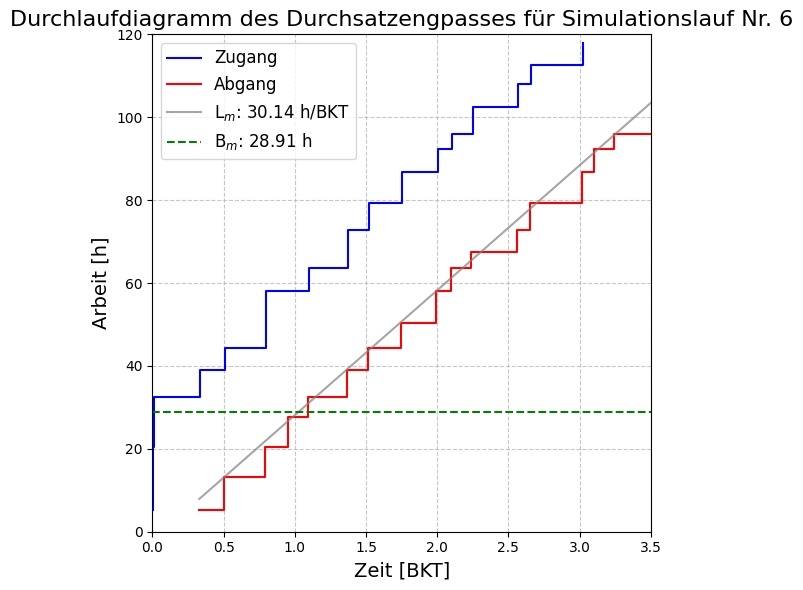

In [148]:
import matplotlib.pyplot as plt

# Verbindung zur bestehenden Datenbank herstellen
conn = sqlite3.connect('prod_data.db')
cursor = conn.cursor()

# Abfrage, um alle Tabellen in der Datenbank anzuzeigen
cursor.execute('''
    SELECT ankunft, start_bearbeitung, ende_bearbeitung FROM flf WHERE bmg like "DRH%"
''')
data = cursor.fetchall()
data


df = pd.DataFrame(data, columns=["ankunft", "start", "ende"])

# Umwandeln der Spalten in Datumsformat
df["ankunft"] = pd.to_datetime(df["ankunft"])
df["start"] = pd.to_datetime(df["start"])
df["ende"] = pd.to_datetime(df["ende"])


df["duration"] = (df["ende"] - df["start"]).dt.total_seconds() / (60 * 60)  # Dauer in Stunden

# Anpassung der Dauer:
def adjust_duration(row):
    # Wenn der Auftrag am Freitag startet und in der kommenden Woche endet
    if row["start"].weekday() == 4 and row["ende"].weekday() < 4:
        return row["duration"] - 56  # 48 Stunden abziehen
    # Wenn der Auftrag am Abend startet und am nächsten Tag endet
    elif row["start"].day != row["ende"].day:
        return row["duration"] - 8  # 8 Stunden abziehen
    return row["duration"]  # Keine Änderung

# Dauer für jeden Auftrag anpassen
df["adjusted_duration"] = df.apply(adjust_duration, axis=1)


# Funktion zur Berechnung der Betriebszeit (BKT)
reference_time = pd.to_datetime('2024-01-02 06:00:00')



# Berechnung der Differenz in Stunden
df['days_ankunft'] = (df['ankunft'] - reference_time).dt.total_seconds() / (3600*24)  # In Stunden

for index, row in df.iterrows():
    if row["days_ankunft"] < 4:
        days_integer = int(row['days_ankunft'])  # Ganzzahlteil
        days_decimal = row['days_ankunft'] - days_integer  # Dezimalteil

        # Berechnung der Betriebszeit
        bkt_value = days_integer + (days_decimal * 24 / 16)  # Ganzzahlteil + (Dezimalteil * 24 / 16)

        # Zuweisung der BKT-Werte
        df.loc[index, 'bkt_ankunft'] = bkt_value
    elif row["days_ankunft"] > 5:
        days_integer = int(row['days_ankunft'])-2  # Ganzzahlteil
        days_decimal = row['days_ankunft'] - (days_integer +2)  # Dezimalteil

        # Berechnung der Betriebszeit
        bkt_value = days_integer + (days_decimal * 24 / 16)  # Ganzzahlteil + (Dezimalteil * 24 / 16)

        # Zuweisung der BKT-Werte
        df.loc[index, 'bkt_ankunft'] = bkt_value

        # Berechnung der Differenz in Stunden
df['days_ende'] = (df['ende'] - reference_time).dt.total_seconds() / (3600*24)  # In Stunden

for index, row in df.iterrows():
    if row["days_ende"] < 4:
        days_integer = int(row['days_ende'])  # Ganzzahlteil
        days_decimal = row['days_ende'] - days_integer  # Dezimalteil

        # Berechnung der Betriebszeit
        bkt_value = days_integer + (days_decimal * 24 / 16)  # Ganzzahlteil + (Dezimalteil * 24 / 16)

        # Zuweisung der BKT-Werte
        df.loc[index, 'bkt_ende'] = bkt_value
    elif row["days_ende"] > 5:
        days_integer = int(row['days_ende'])-2  # Ganzzahlteil
        days_decimal = row['days_ende'] - (days_integer +2) # Dezimalteil

        # Berechnung der Betriebszeit
        bkt_value = days_integer + (days_decimal * 24 / 16)  # Ganzzahlteil + (Dezimalteil * 24 / 16)

        # Zuweisung der BKT-Werte
        df.loc[index, 'bkt_ende'] = bkt_value

# Sortiere den DataFrame nach der 'start' Zeit
df_copy = df.sort_values(by="bkt_ankunft")

# Speichere die sortierten 'start' Werte in der Liste
zugang_x = list(df_copy['bkt_ankunft'])

zugang_y = df['adjusted_duration'].cumsum()
zugang_y_copy = df['adjusted_duration']

abgang_x= list(df['bkt_ende'])
abgang_y= df['adjusted_duration'].cumsum()
abgang_y_copy = df['adjusted_duration']

bestand = []
bestand_time = []
curr_abgang = 0
for idx, zugang in enumerate(zugang_x):
    while True:
        if zugang_x[idx] < abgang_x[curr_abgang]:
            if len(bestand)==0:
                bestand.append(zugang_y_copy[idx])
            else:
                bestand.append((bestand[-1] + zugang_y_copy[idx]))
            
            bestand_time.append( zugang_x[idx])
            break
        elif zugang_x[idx] >= abgang_x[curr_abgang]:
            bestand.append((bestand[-1] - abgang_y_copy[curr_abgang]))
            bestand_time.append(abgang_x[curr_abgang])
            curr_abgang += 1

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Diagramm erstellen
plt.figure(figsize=(6, 6))

# Zugangskurve plotten
plt.step(zugang_x, zugang_y, where='post', label='Zugang', color='blue')

# Abgangskurve plotten
plt.step(abgang_x, abgang_y, where='post', label='Abgang', color='red')

# Abgangskurve plotten
#plt.step(bestand_time, bestand, where='post', label='Abgang', color='green', alpha = 0.7)
abgang_x_array = np.array(abgang_x).reshape(-1, 1)  # Feature-Matrix
abgang_y_array = np.array(abgang_y)

# Lineare Regression
model = LinearRegression()
model.fit(abgang_x_array, abgang_y_array)

# Ergebnisse der Regression
m = model.coef_[0]  # Steigung (mittlere Leistung)
b = model.intercept_  # Achsenabschnitt

plt.plot(abgang_x_array, model.predict(abgang_x_array), color='gray', alpha=0.7, label=f'L$_m$: {m:.2f} h/BKT')
mittelwert = np.mean(bestand)
plt.axhline(y=mittelwert, color='green', linestyle='--', label=f'B$_m$: {mittelwert:.2f} h')


#plt.step(zugang_zeiten, bestand, where='post', label='Bestand', color='green', alpha=0.5)




#mittelwert = np.mean(bestand)
#plt.axhline(y=mittelwert, color='green', linestyle='--', label=f'B$_m$: {mittelwert:.2f} h')
# Achsentitel und Legende
plt.title('Durchlaufdiagramm des Durchsatzengpasses für Simulationslauf Nr. 6', fontsize=16)
plt.xlabel('Zeit [BKT]', fontsize=14)
plt.ylabel('Arbeit [h]', fontsize=14)
plt.legend( fontsize=12)
plt.xlim(0,3.5)
plt.ylim(0,120)
plt.grid(axis='both', linestyle='--', alpha=0.7)

plt.xticks(fontsize=10)  # Schriftgröße der x-Achsen-Ticks
plt.yticks(fontsize=10)

# Diagramm anzeigen
plt.tight_layout()
#plt.savefig('simulation_nr6.jpg', format='jpeg', dpi=400,bbox_inches='tight', pad_inches=0.1, facecolor='white')
plt.show()

In [68]:
# Verbindung zur bestehenden Datenbank herstellen
conn = sqlite3.connect('prod_data.db')
cursor = conn.cursor()

# Abfrage, um alle Tabellen in der Datenbank anzuzeigen
cursor.execute('''
    SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';
''')

# Alle Tabellen auflisten
tables = cursor.fetchall()

# Für jede Tabelle den Inhalt anzeigen
for table in tables:
    table_name = table[0]
    print(f"Inhalt der Tabelle: {table_name}")
    
    # Inhalt der Tabelle abfragen
    cursor.execute(f'SELECT * FROM {table_name}')
    rows = cursor.fetchall()
    
    # Spaltennamen der Tabelle anzeigen
    column_names = [description[0] for description in cursor.description]
    print(column_names)  # Spaltennamen drucken
    
    # Inhalt der Tabelle Zeile für Zeile drucken
    for row in rows:
        print(row)
    print("\n" + "-"*50 + "\n")  # Trennlinie für bessere Lesbarkeit

# Verbindung schließen
conn.close()

Inhalt der Tabelle: produktstammdaten
['id', 'bezeichnung', 'dlz_plan', 'losgroesse', 'Bestand_RTL', 'Bestand_FTL', 'Bestellbestand']
('A1', 'Gehause', 50, 25, 700, 140, 150)
('A2', 'Deckel', 150, 50, 400, 170, 250)
('A3', 'Zylinderrohr', 200, 50, 330, 310, 250)
('A4', 'Zylinderboden', 200, 100, 530, 70, 300)
('A5', 'Kolbenstange', 200, 50, 530, 230, 190)
('A6', 'Zahnrad', 200, 100, 530, 230, 500)
('A7', 'Welle', 200, 25, 530, 190, 150)
('A8', 'Kolben', 200, 100, 330, 310, 250)

--------------------------------------------------

Inhalt der Tabelle: auftraege
['Charge', 'id', 'stueckzahl_plan', 'stueckzahl_ist', 'freigabe', 'fertigstellung', 'art']
(20000000, 'A5', 5, 5, '2024-01-08 21:27:54', '2024-01-09 10:21:54', 'ZU')
(20000001, 'A5', 4, 4, '2024-01-08 19:40:54', '2024-01-09 07:59:54', 'ZU')
(20000002, 'A5', 6, 6, '2024-01-08 15:24:54', '2024-01-08 21:47:54', 'ZU')
(20000003, 'A5', 6, 6, '2024-01-08 13:58:54', '2024-01-08 19:57:54', 'ZU')
(20000004, 'A5', 4, 4, '2024-01-08 08:02:54

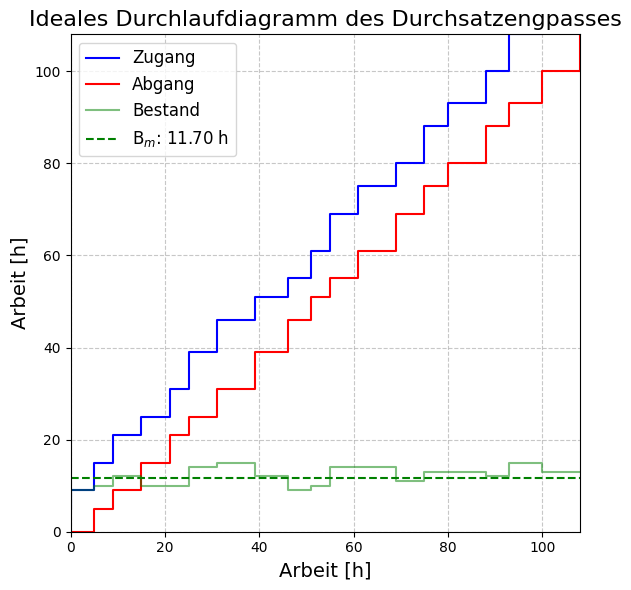

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd

# Daten initialisieren
auftraege = [
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 5, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 4, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 6, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 6, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 4, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 6, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 8, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 7, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 5, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 4, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 6, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 8, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 6, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 5, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 8, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 5, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 7, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 8, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 5, 'start': "02.01.2024 06:00", 'art': 'ZU'},
    {'charge': 999, 'id': 'A5', 'arbeitsplan': [], 'menge': 8, 'start': "02.01.2024 06:00", 'art': 'ZU'}
]

# DataFrame erstellen
auftraege_df = pd.DataFrame(auftraege)

# Kumulative Bearbeitungszeit berechnen
auftraege_df['start_time'] = auftraege_df['menge'].cumsum().shift(fill_value=0).shift(fill_value=0)
auftraege_df['end_time'] = auftraege_df['menge'].cumsum()
bestand = auftraege_df["end_time"] - auftraege_df["start_time"]

# Zugangskurve (Beginn eines Auftrags)
zugang_zeiten = list(auftraege_df['start_time'])
zugang_kurve = list(auftraege_df['end_time'])

# Abgangskurve (Ende eines Auftrags)
abgang_zeiten = list(auftraege_df['start_time'])
abgang_kurve = list(auftraege_df['start_time'])

# Diagramm erstellen
plt.figure(figsize=(6, 6))

# Zugangskurve plotten
plt.step(zugang_zeiten, zugang_kurve, where='post', label='Zugang', color='blue')

# Abgangskurve plotten
plt.step(abgang_zeiten, abgang_kurve, where='post', label='Abgang', color='red')

plt.step(zugang_zeiten, bestand, where='post', label='Bestand', color='green', alpha=0.5)

mittelwert = np.mean(bestand)
plt.axhline(y=mittelwert, color='green', linestyle='--', label=f'B$_m$: {mittelwert:.2f} h')
# Achsentitel und Legende
plt.title('Ideales Durchlaufdiagramm des Durchsatzengpasses', fontsize=16)
plt.xlabel('Arbeit [h]', fontsize=14)
plt.ylabel('Arbeit [h]', fontsize=14)
plt.legend( fontsize=12)
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.xlim(0,108)
plt.ylim(0,108)
plt.xticks(fontsize=10)  # Schriftgröße der x-Achsen-Ticks
plt.yticks(fontsize=10)

# Diagramm anzeigen
plt.tight_layout()

plt.savefig('ideales_durchlaufdiagramm.jpg', format='jpeg', dpi=400,bbox_inches='tight', pad_inches=0.1, facecolor='white')
plt.show()


In [155]:
df = pd.DataFrame(columns=["Lm", "Bm", "Rm"])
# Erstellen eines Vektors von 0 bis 32 in Schritten von 1
lm_values = np.arange(0.5, 32, 3)

# Den Vektor 'Lm' in das DataFrame einfügen
df["Lm"] = lm_values
# Hinzufügen der Werte 31.3, 31.5, 31.8, 31.9 zu 'Lm'
additional_values = pd.DataFrame({"Lm": [31.3, 31.5, 31.8, 31.9, 31.99]})
df = pd.concat([df, additional_values], ignore_index=True)
additional_values = pd.DataFrame({"Lm": [0, 0.1]})
df = pd.concat([additional_values, df], ignore_index=True)

df["Bm"] = 11.7 * df["Lm"] / 32 + 11.7 * 10 * (1-(1-df["Lm"]/32)**(1/4))**4
df["Rm"] = df["Bm"] / df["Lm"]
df

,Lm,Bm,Rm
0,0.00,0.000000,NaN
1,0.10,0.036563,0.365625
2,0.50,0.182813,0.365625
3,3.50,1.279765,0.365647
4,6.50,2.377647,0.365792
5,9.50,3.479343,0.366247
6,12.50,4.591843,0.367347
7,15.50,5.730650,0.369719
8,18.50,6.930037,0.374597
9,21.50,8.269899,0.384646


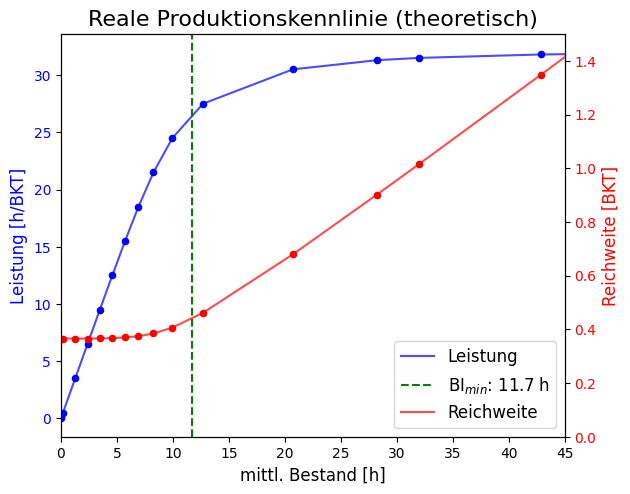

In [156]:
# Erstellen des Plots
fig, ax1 = plt.subplots()

# Plotten der 'Lm' gegen 'Bm' auf der linken y-Achse (mit Scatter und Linie)
ax1.scatter(df["Bm"], df["Lm"], color='blue', marker='o', s=20)
ax1.plot(df["Bm"], df["Lm"], color='blue', linestyle='-', alpha=0.7, label='Leistung')  # Linie hinzufügen
ax1.set_xlabel("mittl. Bestand [h]", fontsize=12)  # x-Achse beschriften
ax1.set_ylabel("Leistung [h/BKT]", color='blue', fontsize=12)  # Linke y-Achse beschriften
ax1.tick_params(axis='y', labelcolor='blue')  # Farbe der tick-Labels der linken Achse

# Erstellen der rechten y-Achse (mit Scatter und Linie)
ax2 = ax1.twinx()
ax2.scatter(df["Bm"], df["Rm"], color='red', marker='o', s=20)
ax2.plot(df["Bm"], df["Rm"], color='red', linestyle='-', alpha=0.7, label='Reichweite')  # Linie hinzufügen
ax2.set_ylabel("Reichweite [BKT]", color='red', fontsize=12)  # Rechte y-Achse beschriften
ax2.tick_params(axis='y', labelcolor='red')  # Farbe der tick-Labels der rechten Achse
ax2.set_ylim(0,1.5)
ax2.set_xlim(0,45)
ax1.axvline(x=11.7, color='green', linestyle='--', label="BI$_{min}$: 11.7 h")
handles, labels = ax1.get_legend_handles_labels()  # Handles und Labels von ax1
handles2, labels2 = ax2.get_legend_handles_labels()  # Handles und Labels von ax2
plt.legend(handles=handles + handles2, labels=labels + labels2, loc='lower right', fontsize=12)

# Diagramm anpassen
fig.tight_layout()  # Layout optimieren
plt.title("Reale Produktionskennlinie (theoretisch)", fontsize=16)  # Titel hinzufügen
plt.savefig('reale produktionskennlinie.jpg', format='jpeg', dpi=400,bbox_inches='tight', pad_inches=0.1, facecolor='white')
plt.show()

In [161]:
df = pd.DataFrame(columns=["Lm", "Bm", "Rm"])
df["Lm"] = [14.57, 19.42, 22, 28.5,29.75, 29.86, 29.96, 30.14]
df["Bm"] = [3.12, 4.97, 6, 7.5,8.84, 10.3, 13.42, 22.75]
df["Rm"] = df["Bm"] / df["Lm"]

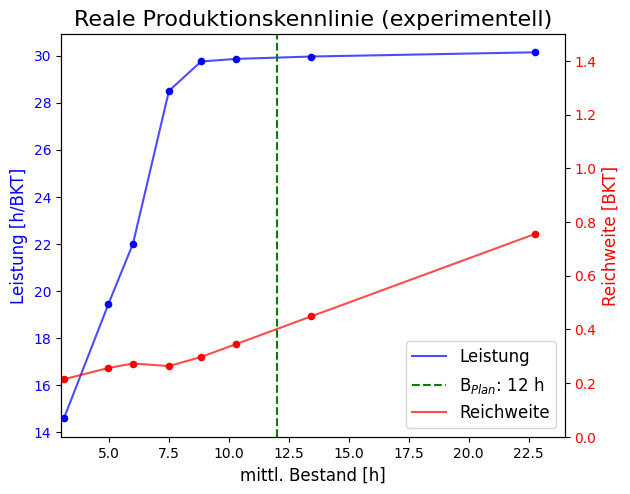

In [164]:
# Erstellen des Plots
fig, ax1 = plt.subplots()

# Plotten der 'Lm' gegen 'Bm' auf der linken y-Achse (mit Scatter und Linie)
ax1.scatter(df["Bm"], df["Lm"], color='blue', marker='o', s=20)
ax1.plot(df["Bm"], df["Lm"], color='blue', linestyle='-', alpha=0.7, label='Leistung')  # Linie hinzufügen
ax1.set_xlabel("mittl. Bestand [h]", fontsize=12)  # x-Achse beschriften
ax1.set_ylabel("Leistung [h/BKT]", color='blue', fontsize=12)  # Linke y-Achse beschriften
ax1.tick_params(axis='y', labelcolor='blue')  # Farbe der tick-Labels der linken Achse

# Erstellen der rechten y-Achse (mit Scatter und Linie)
ax2 = ax1.twinx()
ax2.scatter(df["Bm"], df["Rm"], color='red', marker='o', s=20)
ax2.plot(df["Bm"], df["Rm"], color='red', linestyle='-', alpha=0.7, label='Reichweite')  # Linie hinzufügen
ax2.set_ylabel("Reichweite [BKT]", color='red', fontsize=12)  # Rechte y-Achse beschriften
ax2.tick_params(axis='y', labelcolor='red')  # Farbe der tick-Labels der rechten Achse
ax2.set_ylim(0,1.5)
ax2.set_xlim(3,24)
ax1.axvline(x=12, color='green', linestyle='--', label="B$_{Plan}$: 12 h")
handles, labels = ax1.get_legend_handles_labels()  # Handles und Labels von ax1
handles2, labels2 = ax2.get_legend_handles_labels()  # Handles und Labels von ax2
plt.legend(handles=handles + handles2, labels=labels + labels2, loc='lower right', fontsize=12)

# Diagramm anpassen
fig.tight_layout()  # Layout optimieren
plt.title("Reale Produktionskennlinie (experimentell)", fontsize=16)  # Titel hinzufügen
plt.savefig('reale produktionskennlinie_2.jpg', format='jpeg', dpi=400,bbox_inches='tight', pad_inches=0.1, facecolor='white')
plt.show()